In [1]:
import itertools
import pprint
import warnings

import ibis
from codetiming import Timer

import letsql as ls
import nasa_avionics_data_ml.settings as S
import nasa_avionics_data_ml.zip_data as ZD
from nasa_avionics_data_ml.letsql_udwf_inference import (
    asof_join_flight_data,
    do_manual_batch,
    make_evaluate_all,
    make_rate_to_parquet,
    read_model_and_scales,
    union_cached_asof_joined_flight_data,
)
from nasa_avionics_data_ml.lib import Config

In [2]:
(order_by, group_by) = ("time", "flight")
tail = "Tail_652_1"

return_type = "float64"

In [3]:
(config, *_) = Config.get_debug_configs()
(model, scaleX, scaleT) = read_model_and_scales(config, 0)
for p in S.parquet_cache_path.iterdir():
    p.unlink()
print(tuple(S.parquet_cache_path.iterdir()))

()


## Demonstrate query of remote data into local engine tha

In [4]:
# get 8 flights from tail 652_1
(flight_data, *_) = flight_datas = tuple(itertools.islice(
    next(td for td in ZD.TailData.gen_from_data_dir() if td.tail == tail).gen_parquet_exists(),
    8,
))
single_expr = asof_join_flight_data(flight_data)

In [5]:
pprint.pprint(make_rate_to_parquet(flight_data))
print(ls.to_sql(single_expr))

{0.25: 'https://nasa-avionics-data-ml.s3.us-east-2.amazonaws.com/Tail_652_1_parquet/652200101100441.0p25.parquet',
 1.0: 'https://nasa-avionics-data-ml.s3.us-east-2.amazonaws.com/Tail_652_1_parquet/652200101100441.1p0.parquet',
 2.0: 'https://nasa-avionics-data-ml.s3.us-east-2.amazonaws.com/Tail_652_1_parquet/652200101100441.2p0.parquet',
 4.0: 'https://nasa-avionics-data-ml.s3.us-east-2.amazonaws.com/Tail_652_1_parquet/652200101100441.4p0.parquet',
 8.0: 'https://nasa-avionics-data-ml.s3.us-east-2.amazonaws.com/Tail_652_1_parquet/652200101100441.8p0.parquet',
 16.0: 'https://nasa-avionics-data-ml.s3.us-east-2.amazonaws.com/Tail_652_1_parquet/652200101100441.16p0.parquet'}
SELECT
  *
FROM (
  SELECT
    "t24"."time",
    "t24"."FPAC",
    "t24"."BLAC",
    "t24"."CTAC",
    "t24"."IVV",
    "t24"."flight",
    "t24"."RALT",
    "t24"."PTCH",
    "t24"."ROLL",
    "t24"."VRTG",
    "t24"."TH",
    "t24"."MH",
    "t24"."EGT_1",
    "t24"."EGT_2",
    "t24"."EGT_3",
    "t24"."EGT_4",
  

## Create the deferred udwf expression to run inference

In [6]:
evaluate_all = make_evaluate_all(
    ibis.schema({name: float for name in config.x_names}),
    return_type, model, 8, scaleX, scaleT,
)
expr = union_cached_asof_joined_flight_data(*flight_datas)
window = ibis.window(
    preceding=config.seq_length-1,
    following=0,
    order_by=order_by,
    group_by=group_by,
)
with_prediction = (
    expr
    .mutate(predicted=evaluate_all.on_expr(expr).over(window))
)

## Run inference

In [7]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    with Timer("from_letsql"):
        from_letsql = ls.execute(with_prediction.order_by(group_by, order_by))
print(tuple(S.parquet_cache_path.iterdir()))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Elapsed time: 23.5391 seconds
(PosixPath('/home/dan/repos/github/nasa_avionics_data_ml/nasa_avionics_data_ml/flight-cache/letsql_cache-snapshot-aa121a42408488cb28562698399a3bf1.parquet'), PosixPath('/home/dan/repos/github/nasa_avionics_data_ml/nasa_avionics_data_ml/flight-cache/letsql_cache-snapshot-0468370373dc616aec9789adee29c0f3.parquet'), PosixPath('/home/dan/repos/github/nasa_avionics_data_ml/nasa_avionics_data_ml/flight-cache/letsql_cache-snapshot-b05a9178ff3a4da8c0aa7905ff9ffb69.parquet'), PosixPath('/home/dan/repos/github/nasa_avionics_data_ml/nasa_avionics_data_ml/flight-cache/letsql_cache-snapshot-43b869d8746ffdf04c77d0b7f40207a0.parquet'), PosixPath('/home/dan/repos/github/nasa_avionics_data_ml/nasa_avionics_data_ml/flight-cache/letsql_cache-snapshot-e0d6c21507d353cd4ab9aecc6895c84d.parquet'), PosixPath('/home/dan/repos/github/nasa_avionics_data_ml/nasa_avionics_data_ml/flight-cache/letsql_cache-snapshot-76e9d977fe6e464474a194ab72e6939e.parquet'), PosixPath('/home/dan/repos/

In [8]:
# clear the cache
for p in S.parquet_cache_path.iterdir(): p.unlink()
with Timer("from_manual"):
    from_manual = (
        do_manual_batch(expr, model, config.seq_length, scaleX, scaleT, return_type, config.xlist, group_by, order_by)
        .sort_values([group_by, order_by], ignore_index=True)
    )

Elapsed time: 20.8182 seconds


In [9]:
assert from_manual.equals(from_letsql)

In [10]:
# run with warm cache
with Timer("from_letsql cached"):
    from_letsql = ls.execute(with_prediction.order_by(group_by, order_by))
print(tuple(S.parquet_cache_path.iterdir()))

/home/dan/repos/github/nasa_avionics_data_ml/venv/lib/python3.10/site-packages/letsql/expr/relations.py:131: FutureWarning: `Backend.register` is deprecated as of v9.1; use the explicit `read_*` method for the filetype you are trying to read, e.g., read_parquet, read_csv, etc.
  node.source.register(batches, table_name=node.name)
/home/dan/repos/github/nasa_avionics_data_ml/venv/lib/python3.10/site-packages/ibis/backends/duckdb/__init__.py:559: FutureWarning: `Backend.read_in_memory` is deprecated as of v9.1, removed in v10.0; Pass in-memory data to `memtable` instead.
  return self.read_in_memory(source, table_name=table_name, **kwargs)
/home/dan/repos/github/nasa_avionics_data_ml/venv/lib/python3.10/site-packages/letsql/expr/relations.py:110: FutureWarning: `Backend.register` is deprecated as of v9.1; use the explicit `read_*` method for the filetype you are trying to read, e.g., read_parquet, read_csv, etc.
  remote.source.register(batches, table_name=name)


Elapsed time: 6.8710 seconds
(PosixPath('/home/dan/repos/github/nasa_avionics_data_ml/nasa_avionics_data_ml/flight-cache/letsql_cache-snapshot-aa121a42408488cb28562698399a3bf1.parquet'), PosixPath('/home/dan/repos/github/nasa_avionics_data_ml/nasa_avionics_data_ml/flight-cache/letsql_cache-snapshot-0468370373dc616aec9789adee29c0f3.parquet'), PosixPath('/home/dan/repos/github/nasa_avionics_data_ml/nasa_avionics_data_ml/flight-cache/letsql_cache-snapshot-b05a9178ff3a4da8c0aa7905ff9ffb69.parquet'), PosixPath('/home/dan/repos/github/nasa_avionics_data_ml/nasa_avionics_data_ml/flight-cache/letsql_cache-snapshot-43b869d8746ffdf04c77d0b7f40207a0.parquet'), PosixPath('/home/dan/repos/github/nasa_avionics_data_ml/nasa_avionics_data_ml/flight-cache/letsql_cache-snapshot-e0d6c21507d353cd4ab9aecc6895c84d.parquet'), PosixPath('/home/dan/repos/github/nasa_avionics_data_ml/nasa_avionics_data_ml/flight-cache/letsql_cache-snapshot-76e9d977fe6e464474a194ab72e6939e.parquet'), PosixPath('/home/dan/repos/g

## Inspect the data, evaulate inference

In [11]:
from_letsql

,time,FPAC,BLAC,CTAC,IVV,flight,RALT,PTCH,ROLL,VRTG,...,ESN_3,ECYC_3,ECYC_4,EHRS_1,EHRS_4,EHRS_3,EHRS_2,ESN_1,ESN_2,predicted
0,33656.280965,0.270629,0.274537,-0.006839,-17.0,652200101120916,0.0,0.252678,-0.109860,0.985545,...,8095.0,6713.0,7390.0,8601.0,7133.0,6361.0,5634.0,7882.0,7833.0,NaN
1,33656.343522,0.271606,0.274537,-0.003908,-21.0,652200101120916,0.0,0.252678,-0.109860,0.985545,...,8095.0,6713.0,7390.0,8601.0,7133.0,6361.0,5634.0,7882.0,7833.0,NaN
2,33656.406079,0.271606,0.274537,-0.009770,-24.0,652200101120916,0.0,0.230706,-0.076903,0.978678,...,8095.0,6713.0,7390.0,8601.0,7133.0,6361.0,5634.0,7882.0,7833.0,NaN
3,33656.468636,0.271606,0.274537,-0.003908,-24.0,652200101120916,0.0,0.230706,-0.076903,0.978678,...,8095.0,6713.0,7390.0,8601.0,7133.0,6361.0,5634.0,7882.0,7833.0,NaN
4,33656.531193,0.267698,0.270629,-0.006839,-24.0,652200101120916,0.0,0.219720,-0.054930,0.994701,...,8095.0,6713.0,7390.0,8601.0,7133.0,6361.0,5634.0,7882.0,7833.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331055,4519.477061,-0.217871,-0.229595,-0.000977,-33.0,652200101130002,0.0,-0.604231,0.175776,0.985545,...,8095.0,6717.0,7394.0,8605.0,7137.0,6365.0,5638.0,7882.0,7833.0,-487.514038
331056,4519.539617,-0.218848,-0.229595,-0.005862,-33.0,652200101130002,0.0,-0.637189,0.175776,0.978678,...,8095.0,6717.0,7394.0,8605.0,7137.0,6365.0,5638.0,7882.0,7833.0,-487.057465
331057,4519.602174,-0.214940,-0.227641,-0.014655,-27.0,652200101130002,0.0,-0.637189,0.175776,0.978678,...,8095.0,6717.0,7394.0,8605.0,7137.0,6365.0,5638.0,7882.0,7833.0,-487.640961
331058,4519.664731,-0.213963,-0.226664,-0.009770,-21.0,652200101130002,0.0,-0.637189,0.186762,1.013013,...,8095.0,6717.0,7394.0,8605.0,7137.0,6365.0,5638.0,7882.0,7833.0,-487.020538


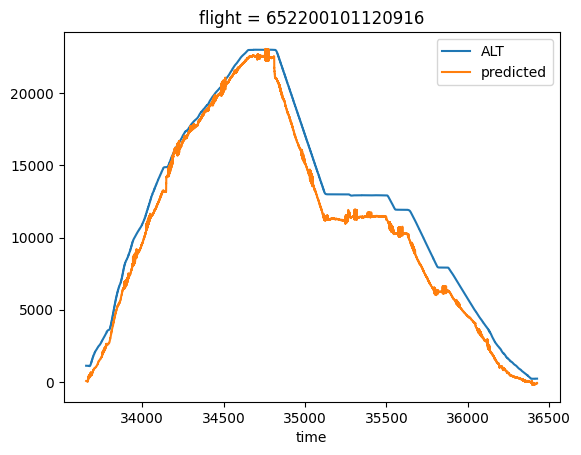

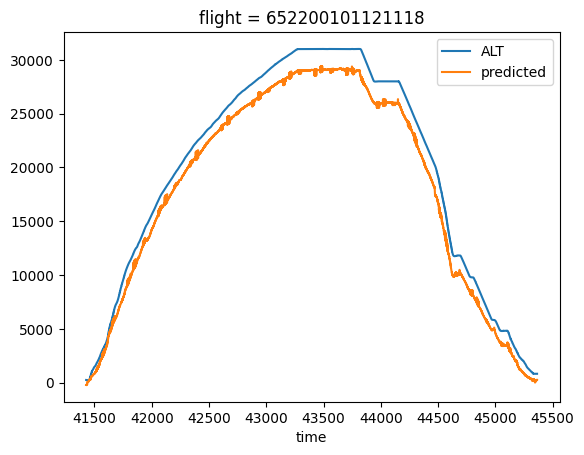

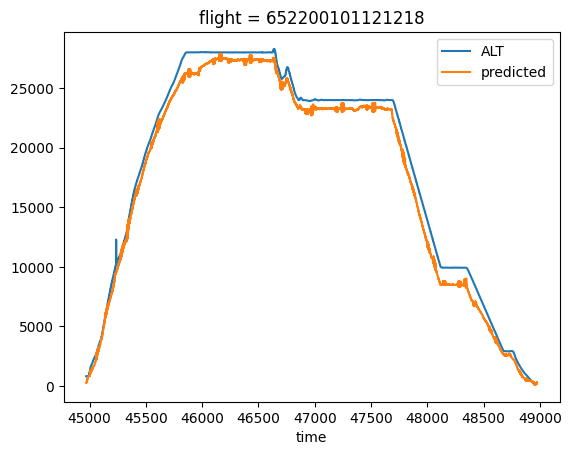

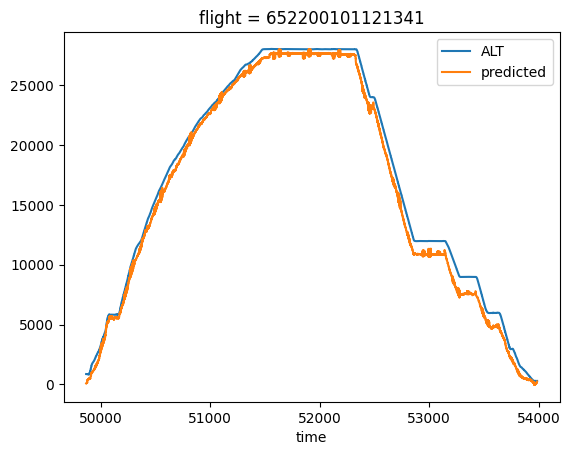

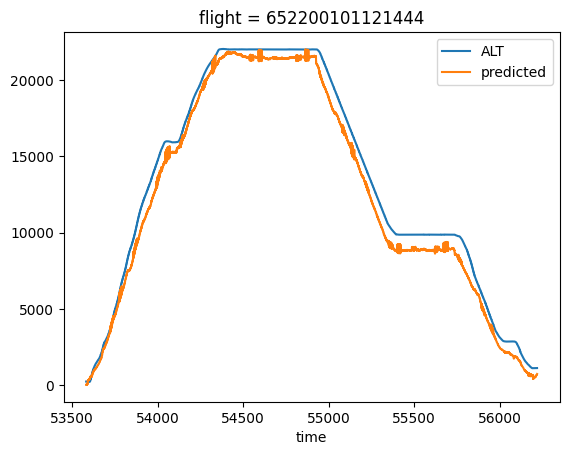

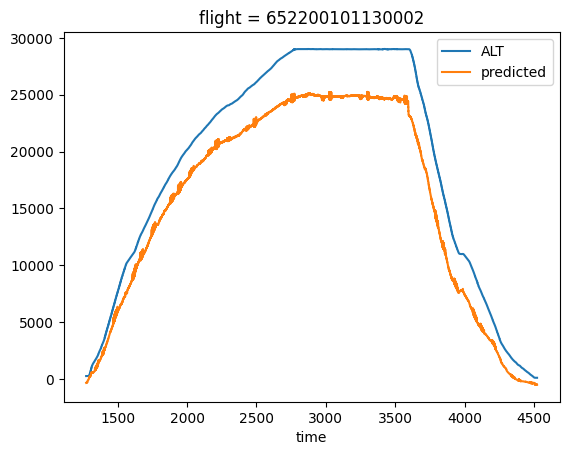

In [12]:
for (flight, df) in from_letsql.groupby("flight"):
    ax = df.set_index("time")[["ALT", "predicted"]].plot()
    ax.set_title(f"flight = {flight:}")